# Module 3: Analyzing Election Results and Polls

In [1]:
# Inline Chart Parameters
%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

# R imports
%load_ext rpy2.ipython

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import pandas as pd
import numpy as np
import us
from utils import download_pres_results
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
%%R

smartRequire <- function(pkg) {
  if (!require(pkg, character.only = T)) { install.packages(pkg, repos='http://cran.us.r-project.org') }
  require(pkg, character.only = T)
}

libs <- c("ggplot2", "theme538", "readr", "extrafont", "Cairo")
lapply(libs, smartRequire)
sprintf("Successfully loaded: %s", libs)


[1] "Successfully loaded: ggplot2"   "Successfully loaded: theme538" 
[3] "Successfully loaded: readr"     "Successfully loaded: extrafont"
[5] "Successfully loaded: Cairo"    


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Step 1: Download Data
- [Election Results](https://docs.google.com/spreadsheets/d/1D-edaVHTnZNhVU840EPUhz3Cgd7m39Urx7HM8Pq6Pus/edit#gid=29622862)
- Population Estimates By State
- [Polls](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)
- [Pollster Ratings](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)
- Census

## Election Results

### PVI

In [12]:
pres_results_raw = download_pres_results()

def state_to_abbrev(state):
    return us.states.lookup(state).abbr
pres_results_national = pres_results_raw[pres_results_raw.state == 'Nationwide']
pres_results_national['d_margin'] = pres_results_national.DEM - pres_results_national.REP

pres_results_by_state = pres_results_raw[~pres_results_raw.state.isin(['Washington DC','Nationwide'])]
pres_results_by_state['d_margin'] = pres_results_by_state.DEM - pres_results_by_state.REP

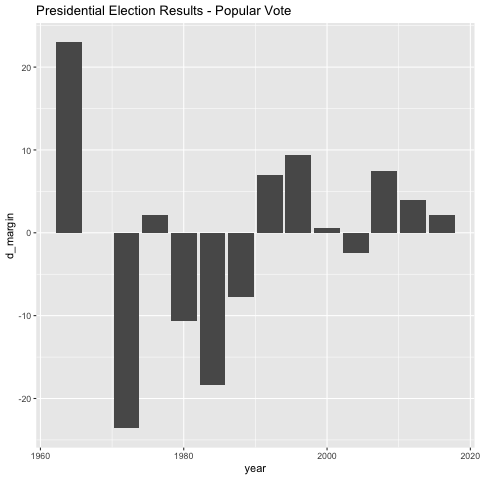

In [13]:
%%R -i pres_results_national
# pres_results_national
ggplot(data=pres_results_national,aes(x=year, y=d_margin)) + 
geom_bar(stat="identity") +
ggtitle("Presidential Election Results - Popular Vote")

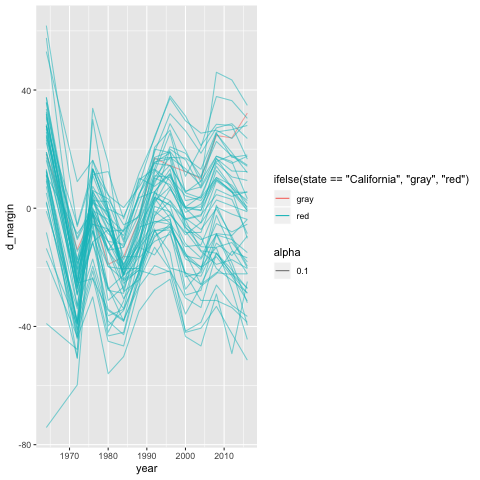

In [26]:
%%R -i pres_results_by_state

pres_results_by_state
ggplot(data=pres_results_by_state,aes(x=year, y=d_margin, group=state, alpha=.1,col = ifelse(state=='California','gray','red'))) + 
geom_line()

In [15]:
pres_results_national.head()

,DEM,REP,year,state,d_margin
1,51.099998,48.900002,2016,Nationwide,2.199997
1,52.000000,48.000000,2012,Nationwide,4.000000
1,53.700001,46.299999,2008,Nationwide,7.400002
1,48.799999,51.200001,2004,Nationwide,-2.400002
1,50.299999,49.700001,2000,Nationwide,0.599998


In [29]:
df = pres_results_by_state

df['previous_year'] = df.year - 4

df = pd.merge(
    df, 
    pres_results_by_state[['year','state','REP', 'DEM']],
    how='left', left_on=('previous_year', 'state'), right_on=('year', 'state'), suffixes=('','_previous_year'))

df = pd.merge(
    df, 
    pres_results_national[['year','REP', 'DEM']],
    how='left', on='year', suffixes=('','_national'))

df = pd.merge(
    df, 
    pres_results_national[['year','REP', 'DEM']],
    how='left', left_on='previous_year', right_on='year', suffixes=('','_previous_year_national'))

del df['year_previous_year_national']
del df['year_previous_year']

df['pvi'] = (df['REP'] * .5 + df['REP_previous_year'] * .5 ) - (df['REP_national'] *.5 + df['REP_previous_year_national'] * .5)
df['fte_pvi'] = (df['REP'] * .75 + df['REP_previous_year'] * .25 ) - (df['REP_national'] *.75 + df['REP_previous_year_national'] * .25)

df[df['year'] == 2016].head()
pvi_df = df

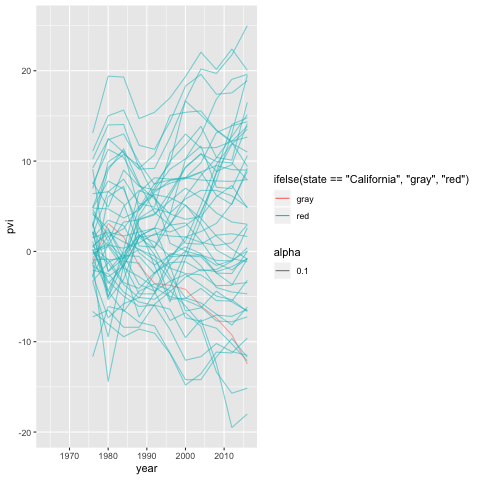

In [30]:
%%R -i df

pres_results_by_state
ggplot(data=df,aes(x=year, y=pvi, group=state, alpha=.1,col = ifelse(state=='California','gray','red'))) + 
geom_line()